In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
% matplotlib inline

# Load pickled data frame

In [2]:
df_csvfile = '../workdir/aloi/hmax_df.pickle'

In [3]:
df = pickle.load(open( df_csvfile, "rb" ))

In [4]:
#df.head()

In [5]:
# how many object categories are in this selection?
print(len(np.unique(df.category.values)))
# how many exemplars per category (i.e. rotations)
print(len(np.unique(df.exemplar.values)))

237
8


In [6]:
# sort df by category
df = df.sort_values(by=['category'])

In [7]:
# z-standardize all typicality measures
for colname in ['ri_typicality', 'intact_typicality', 'conserved_typicality']:
    df['%s_z' % colname] = (df[colname] - np.mean(df[colname].values)) / np.std(df[colname].values)

In [8]:
def add_category_names(df, csv_filepath='../aloi_selection.csv'):

    # make df with category (as number) and category name
    db_df = pd.read_csv(csv_filepath, sep=';')
    db_df['category'] = db_df['db-number'].values
    db_df = db_df.drop(columns=['description', 'database', 'path', 'usedby', 'viewpoints', 'exemplars', 'db-number'])

    # transform df.category into string for both data framees
    df.category = df.category.astype('str')
    db_df.category = db_df.category.astype('str')

    # insert category_name into data frame with patterns
    for cat, catname in zip(db_df.category.values.tolist(), db_df.name.values.tolist()):
        df.loc[df['category'] == cat, 'category_name'] = catname

    # make data type categorical again for plotting
    df.category = df.category.astype('category')
    df.category_name = df.category_name.astype('category')
    
    return df

df = add_category_names(df)

In [9]:
df.head()

,category,exemplar,ri_pattern,intact_pattern,ri_typicality,intact_typicality,conserved_typicality,ri_typicality_z,intact_typicality_z,conserved_typicality_z,category_name
216,1000,r315,"[0.3373489176023908, 0.4672859788353181, 0.462...","[0.8011327160479519, 0.8492840092133004, 0.861...",6.998937,6.970729,6.772198,0.541040,1.014349,-1.221080,strawberry cake
500,1000,r90,"[0.3559807697938108, 0.4901682974712467, 0.490...","[0.8192158461418688, 0.8470693749386655, 0.841...",6.999529,6.974852,6.784868,0.809414,1.142067,-0.998599,strawberry cake
959,1000,r225,"[0.3635987626915047, 0.5047781268538396, 0.501...","[0.8014174730650613, 0.8706640568497859, 0.858...",6.999426,6.969868,6.790051,0.762976,0.987676,-0.907584,strawberry cake
1476,1000,r45,"[0.3595883782298609, 0.4955725363990855, 0.482...","[0.8071519194556434, 0.8435159419840684, 0.836...",6.999567,6.972924,6.781590,0.826683,1.082329,-1.056163,strawberry cake
1557,1000,r270,"[0.35265196023670115, 0.4934615945814135, 0.49...","[0.8222420705548287, 0.8534055091123136, 0.857...",6.999389,6.973799,6.783937,0.746166,1.109441,-1.014943,strawberry cake


In [10]:
def order_categories_by(df,
                        typicality_measure='conserved_typicality_z',
                        category_colname='category_name',
                        sort_func=np.mean):
    """
    Get an array of category names sorted by the average (or alternatively other function) of a given 
    typicality measure. Use this to control the category order in plots.
    """
    df_agg = df.groupby(category_colname).agg({typicality_measure:sort_func})
    df_sorted = df_agg.sort_values(by=[typicality_measure])
    ordered_categories = df_sorted.index.values
    ordered_categories = [line.decode('utf-8').strip() for line in ordered_categories]
    
    return ordered_categories

ordered_categories = order_categories_by(df)

# Similarities between typicality measures

## Correlation

- Conserved typicality correlates more strongly with intact than RI simulated typicalities
- 

                        ri_typicality_z  intact_typicality_z  \
ri_typicality_z                1.000000             0.580965   
intact_typicality_z            0.580965             1.000000   
conserved_typicality_z         0.195557             0.348596   

                        conserved_typicality_z  
ri_typicality_z                       0.195557  
intact_typicality_z                   0.348596  
conserved_typicality_z                1.000000  


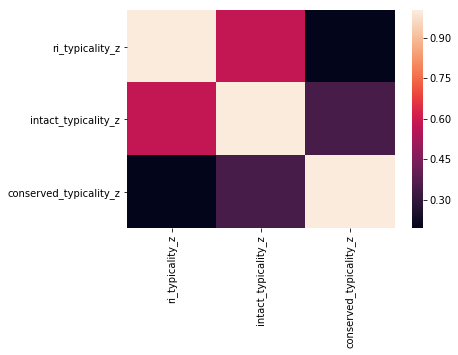

In [11]:
corr_df = df.drop(columns=['ri_typicality', 'intact_typicality', 'conserved_typicality'])
print(corr_df.corr())
sns.heatmap(corr_df.corr())

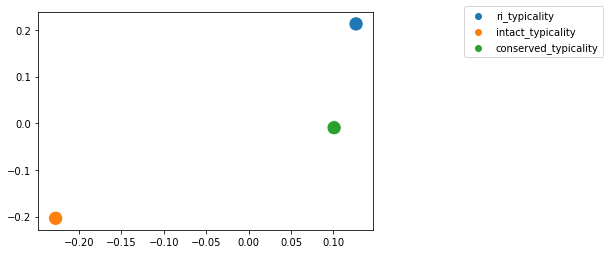

In [12]:
# quick 2d mds plot for correlation coefficients
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=50000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
corr_pos = mds.fit(corr_df.corr()).embedding_

ax = sns.scatterplot(x=corr_pos[:,0], y=corr_pos[:,1],
                hue=['ri_typicality','intact_typicality','conserved_typicality'], 
                legend='brief', s=200)
ax.legend(bbox_to_anchor=(1.7, 1.05))
plt.show()

# Conserved typicality

## Distribution

In [13]:
sns.set_context('talk')
sns.set_style('whitegrid')

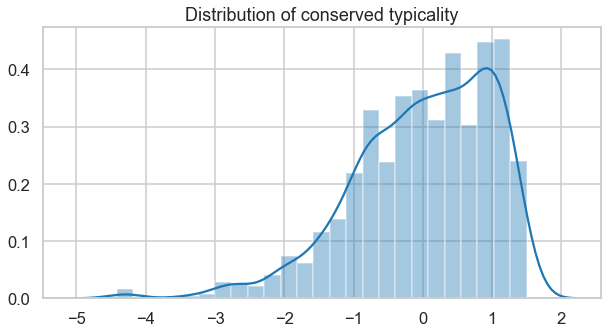

In [14]:
f, axis = plt.subplots(figsize=(10,5))
sns.distplot(df.conserved_typicality_z.values, rug=False, kde=True, ax=axis)
axis.set(title='Distribution of conserved typicality')
plt.show()

## Distribution (violin plot) for individual objects

In [15]:
sns.set_style('whitegrid', {'axes.grid': True, 'xtick.bottom': False, 'xtick.top': False, 'xtick.color': 'gray',
                            'ytick.left': True, 'ytick.right': True, 'ytick.color': 'gray'})

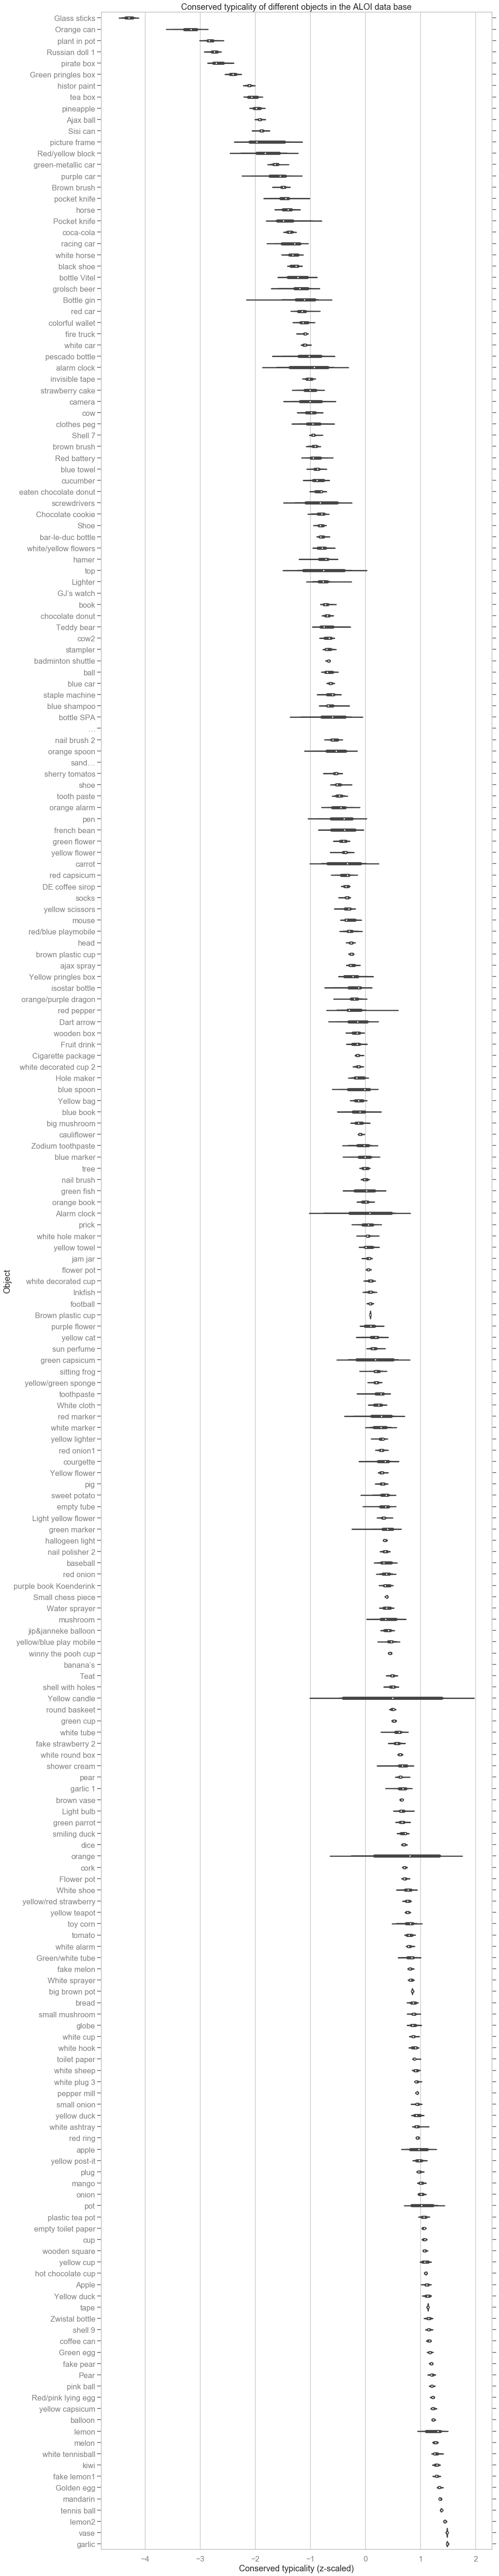

In [16]:
f, axis = plt.subplots(figsize=(15,100))

sns.violinplot(x="conserved_typicality_z", y="category_name", data=df, ax=axis,
               cut=True, order=ordered_categories)

axis.set(title='Conserved typicality of different objects in the ALOI data base',
         ylabel='Object', xlabel='Conserved typicality (z-scaled)')

plt.show()

# TODO: objects with names that are not unicode encoded are not displayed on the plot
#  (though the order should still be correct, since calculated based on the database-id)

# MDS plots

In [17]:
sns.set_style('whitegrid')

In [18]:
# set up a one hot encoded array designating object category
labels_one_hot = np.arange(start=1, stop=238).repeat(8)
print(labels_one_hot)

[  1   1   1 ... 237 237 237]


In [19]:
# optimization parameters
maxiter=50  # increase 
eps_ = 1e-9  # decrease

## RI pattern similarities

In [21]:
# get ri_patterns in array form
ri_patterns = np.array(df.ri_pattern.values.tolist())
print(ri_patterns.shape)

# center data
ri_patterns -= ri_patterns.mean()

# compute dissimilarities
ri_dissimilarities = euclidean_distances(ri_patterns)
print(ri_dissimilarities.shape)

# set up and apply mds
mds = manifold.MDS(n_components=2, max_iter=maxiter, eps=eps_, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)  # increase max_iter / decrease eps for higher precision
ri_pos = mds.fit(ri_dissimilarities).embedding_
print(ri_pos.shape)

# Rotate the data to match first 2 PCs
clf = PCA(n_components=2)
ri_pos = clf.fit_transform(ri_pos)

(1896, 2000)
(1896, 1896)
(1896, 2)


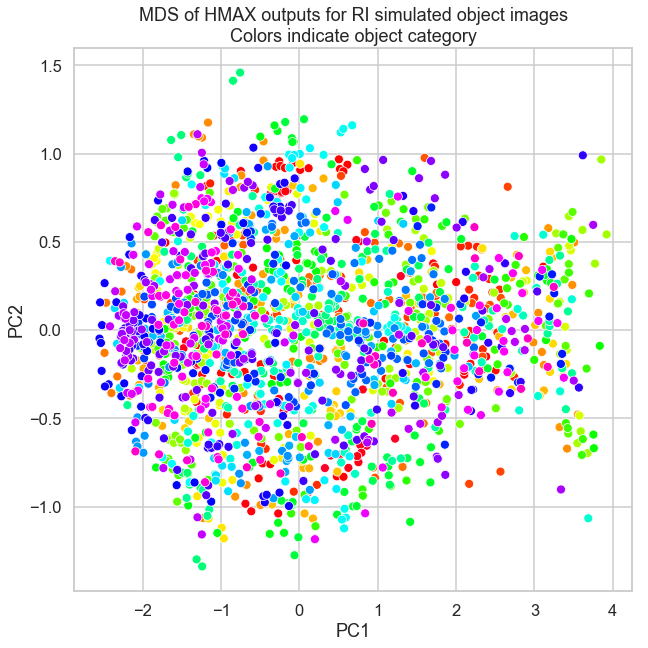

In [22]:
# plot the result
fig, axis = plt.subplots(figsize=(10,10))

sns.scatterplot(x=ri_pos[:,0], y=ri_pos[:,1], hue=labels_one_hot, palette='gist_rainbow', legend=False, ax=axis)
axis.set(title='MDS of HMAX outputs for RI simulated object images\nColors indicate object category',
         xlabel='PC1', ylabel='PC2')

plt.show()

## Intact pattern similarities

In [23]:
# get intact_patterns in array form
intact_patterns = np.array(df.intact_pattern.values.tolist())
print(intact_patterns.shape)

# center data
intact_patterns -= intact_patterns.mean()

# compute dissimilarities
intact_dissimilarities = euclidean_distances(intact_patterns)
print(intact_dissimilarities.shape)

# set up and apply mds
mds = manifold.MDS(n_components=2, max_iter=maxiter, eps=eps_, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)  # increase max_iter / decrease eps for higher precision
intact_pos = mds.fit(intact_dissimilarities).embedding_
print(intact_pos.shape)

# Rotate the data to match first 2 PCs
clf = PCA(n_components=2)
intact_pos = clf.fit_transform(intact_pos)

(1896, 2000)
(1896, 1896)
(1896, 2)


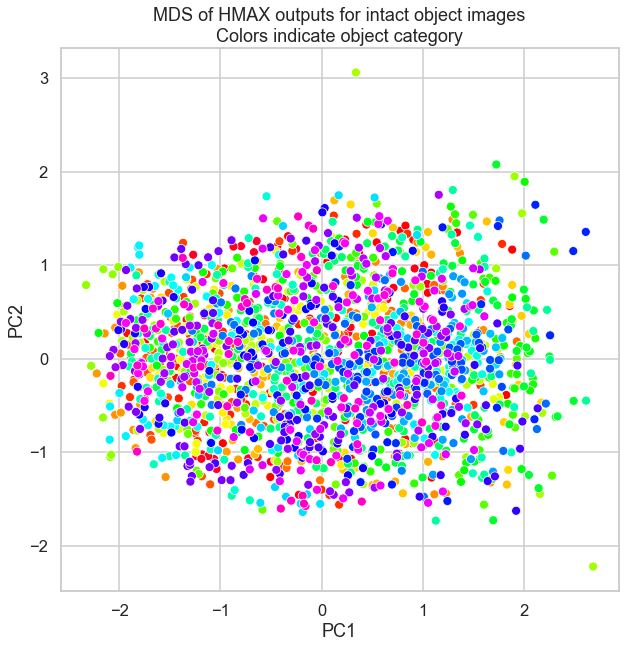

In [24]:
# plot the result
fig, axis = plt.subplots(figsize=(10,10))

sns.scatterplot(x=intact_pos[:,0], y=intact_pos[:,1], hue=labels_one_hot, legend=False, ax=axis,
                palette='gist_rainbow')
axis.set(title='MDS of HMAX outputs for intact object images\nColors indicate object category',
         xlabel='PC1', ylabel='PC2')
plt.show()

# Plot both ri and intact patterns in one MDS

In [25]:
long_df = pd.melt(df, id_vars=['category', 'exemplar'], value_vars=['ri_pattern', 'intact_pattern'])

In [26]:
long_df.head()

,category,exemplar,variable,value
0,1000,r315,ri_pattern,"[0.3373489176023908, 0.4672859788353181, 0.462..."
1,1000,r90,ri_pattern,"[0.3559807697938108, 0.4901682974712467, 0.490..."
2,1000,r225,ri_pattern,"[0.3635987626915047, 0.5047781268538396, 0.501..."
3,1000,r45,ri_pattern,"[0.3595883782298609, 0.4955725363990855, 0.482..."
4,1000,r270,ri_pattern,"[0.35265196023670115, 0.4934615945814135, 0.49..."


In [49]:
# get hmax patterns in array form
patterns = np.array(long_df.value.values.tolist())
# center data
patterns -= patterns.mean()
# compute dissimilarities
dissimilarities = euclidean_distances(patterns)
# set up and apply mds
seed = np.random.RandomState(seed=3)
"""
TODO: This MDS (for some reason) takes a very long time.
 On my laptop, only 10 iterations with low precision (high eps) were feasible.
 For a serious attempt, I'd have to try it on the cluster.
"""
maxiter = 10
eps_ = 1e-1
print('set up')
mds = manifold.MDS(n_components=2, max_iter=maxiter, eps=eps_, random_state=seed,
                   dissimilarity="precomputed", n_jobs=2)
print('fitting')
pos = mds.fit(dissimilarities).embedding_
# Rotate the data to match first 2 PCs
print('pca')
clf = PCA(n_components=2)
pos = clf.fit_transform(pos)

set up
fitting
pca


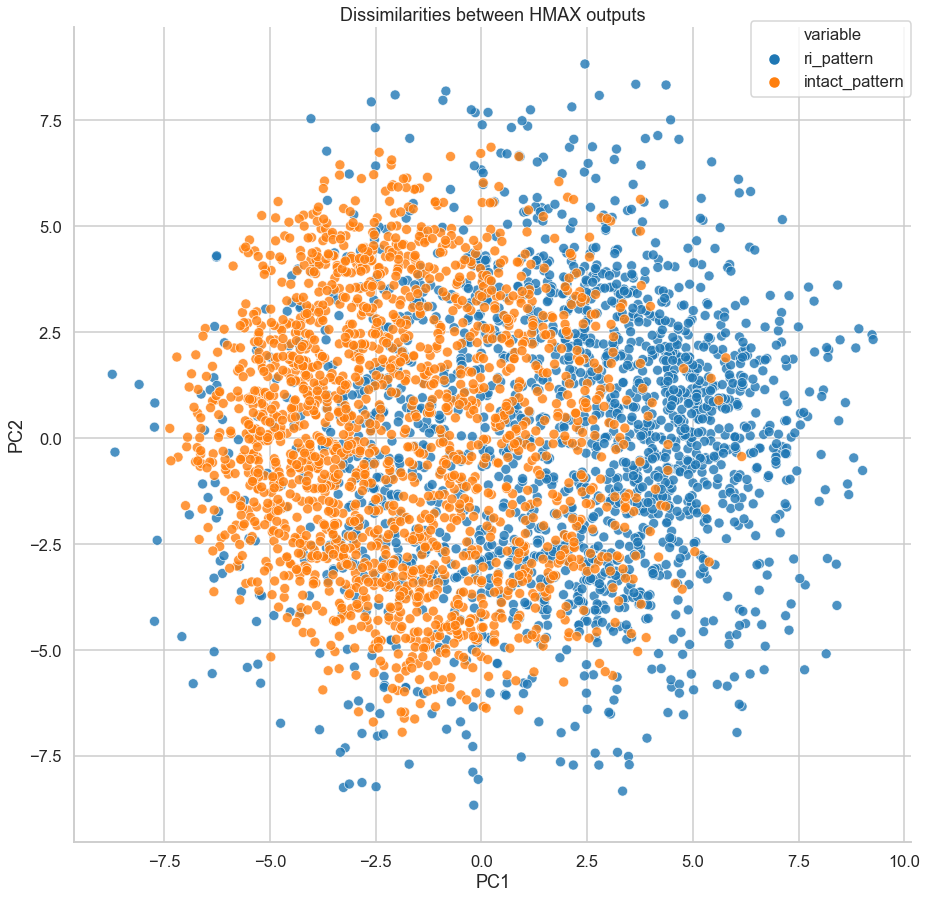

In [48]:
# plot by vision type and category
fig, axis = plt.subplots(figsize=(15,15))
sns.scatterplot(x=pos[:,0], y=pos[:,1], legend='brief', ax=axis,
                alpha=.8, s=100, hue=long_df.variable)
axis.set(title='Dissimilarities between HMAX outputs',
         xlabel='PC1', ylabel='PC2')
axis.legend(bbox_to_anchor=(1.01, 1.017))
sns.despine()
plt.show()

Again, we see that the first PC captures the difference between vision types. The other PCs (as seen here and in the other two MDS plots above) seem insuficient to really cluster by object category.

# TODO: Fit ri_patterns and intact_patterns to a categorical model matrix

In [ ]:
# construct category model RDM
# TODO: continue here

n_exemplars = 8
n_objects = 237

firstcol = np.array(([0] * n_exemplars + [1] * ((n_objects*n_exemplars) - n_exemplars)))
print(firstcol)